In [1]:
project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(project_dir)

import torch
from torch import Tensor, nn
from IPDL import TensorKernel

# MatrixEstimator

In [2]:
class MatrixEstimator(nn.Module):
    def __init__(self, sigma = 0.1):
        super(MatrixEstimator, self).__init__()
        
        self.sigma = nn.Parameter(torch.tensor(sigma), requires_grad=False)
        self.x = torch.rand((10, 1))

    def set_sigma(self, sigma: float) -> None:
        self.sigma.data = torch.tensor(sigma)

    def get_sigma(self) -> float:
        return self.sigma.data.item()

    def forward(self, x: Tensor) -> Tensor:
        if not self.training:
            self.x = x.detach().cpu() # To CPU in order to save memory on GPU

        return x

    def get_matrix(self, activation= None) -> Tensor:
        '''
            Return matrix A

            @param activation: you can chose any nn.Module if is necesary to apply an activation. 
                It is usefull if you need include an activation at the end of your model to compute 
                the Information Plane.
        '''
        device = self.sigma.device # To the device where parameters are located
        n = self.x.size(0)
        
        if not(activation is None):
            return (TensorKernel.RBF(activation(self.x).flatten(1).to(device), self.sigma) / n)
        else:
            return (TensorKernel.RBF(self.x.flatten(1).to(device), self.sigma) / n)

    def __repr__(self) -> str:
        return "MatrixEstimator(sigma={:.2f})".format(self.sigma)


In [3]:
def MatrixEstimatorTest():
    model = nn.Sequential(
        nn.Identity(),
        MatrixEstimator(8),
        nn.Identity(),
        MatrixEstimator(0.5),
        nn.Identity(),
        MatrixEstimator(0.100001)
    )
    model.eval()
    
    x = torch.rand(10, 10)
    y = model(x)

    Ax_0 = TensorKernel.RBF(x, sigma=8) / x.size(0)
    Ax_1 = TensorKernel.RBF(x, sigma=0.5) / x.size(0)
    Ax_2 = TensorKernel.RBF(x, sigma=0.100001) / x.size(0)

    case_0 = all((model[1].get_matrix() == Ax_0).flatten())
    print("Test 0: {}".format(case_0))

    case_1 = all((model[3].get_matrix() == Ax_1).flatten())
    print("Test 1: {}".format(case_1))

    case_2 = all((model[5].get_matrix() == Ax_2).flatten())
    print("Test 2: {}".format(case_2))
    

MatrixEstimatorTest()

Test 0: True
Test 1: True
Test 2: True


# ClassificationInformationPlane

In [4]:
from IPDL import MatrixBasedRenyisEntropy as renyis

class InformationPlane():
    def __init__(self):
        self.Ixt = []
        self.Ity = []

    def getMutualInformation(self, moving_average_n = 0):
        if moving_average_n == 0:
            return self.Ixt, self.Ity
        else:
            filter_Ixt = list(map(lambda Ixt: mva(Ixt, moving_average_n), self.Ixt))
            filter_Ity = list(map(lambda Ity: mva(Ity, moving_average_n), self.Ity))
            return filter_Ixt, filter_Ity
        
    def computeMutualInformation(self, Ax: Tensor, Ay: Tensor):
        raise NotImplementedError("Please Implement this method")
    


class ClassificationInformationPlane(InformationPlane):
    '''
        Pass a list of tensor which contents the matrices in order to calculate the
        MutualInformation

        IP implementaiton that works for classification problems.
    '''

    def __init__(self, model: nn.Module, use_softmax=True):
        '''
            @param model: model where 
            @param softmax: include a softmax layer at the end of the model. It is usefull 
                if your model does not contain this layer. 
        '''
        super(ClassificationInformationPlane, self).__init__()
        self.matrices_per_layers = []
        self.use_softmax = use_softmax
      
        # First element corresponds to input A matrix and last element
        # is the output A matrix
        for module in model.modules():
            if isinstance(module, (MatrixEstimator)):
                self.matrices_per_layers.append(module)

        # self.Ixt = []
        # self.Ity = []
        for i in range(len(self.matrices_per_layers)):
            self.Ixt.append([])
            self.Ity.append([])
    
    def computeMutualInformation(self, Ax: Tensor, Ay: Tensor):
        for idx, matrix_estimator in enumerate(self.matrices_per_layers):
            activation = None 
            if self.use_softmax and idx == len(self.matrices_per_layers)-1 :
                activation = nn.Softmax() 
            
            # if isinstance(activation, nn.Softmax):
            #     print("Softmax in layer {}".format(idx))

            Ixt = renyis.mutualInformation(Ax, matrix_estimator.get_matrix(activation)).cpu()
            Ity = renyis.mutualInformation(matrix_estimator.get_matrix(activation), Ay).cpu()

            self.Ixt[idx].append(Ixt)
            self.Ity[idx].append(Ity)

    # def getMutualInformation(self, moving_average_n = 0):
    #     if moving_average_n == 0:
    #         return self.Ixt, self.Ity
    #     else:
    #         filter_Ixt = list(map(lambda Ixt: mva(Ixt, moving_average_n), self.Ixt))
    #         filter_Ity = list(map(lambda Ity: mva(Ity, moving_average_n), self.Ity))
    #         return filter_Ixt, filter_Ity

# MatrixOptimizer

In [5]:
class MatrixOptimizer():
    def __init__(self, model: nn.Module, beta=0.5, n_sigmas=300):
        if not(0 <= beta <= 1):
            raise Exception('beta must be in the range [0, 1]')

        self.matrix_estimators = []
        # First element corresponds to input A matrix and last element
        # is the output A matrix
        for module in model.modules():
            if isinstance(module, (MatrixEstimator)):
                self.matrix_estimators.append(module)

        self.beta = beta
        self.n_sigmas = n_sigmas

        #just for debugging
        self.sigma_prev = [-1] * len(self.matrix_estimators)
        for idx, matrix_estimator in enumerate(self.matrix_estimators):
            self.sigma_prev[idx] = [matrix_estimator.get_sigma()]

    def step(self, Ky: Tensor) -> None:
        self.optimize(Ky)
    
    def optimize(self, Ky: Tensor) -> None:
        '''
            This function is used in orter to obtain the optimal kernel width for
            an T DNN layer

            @param layer_output
            @param n_sigmas: number of possible sigma values

            [Descripción del procedimiento]
        '''
        # Ky = Ky.to(self.device)
        device = Ky.device
        for idx, matrix_estimator in enumerate(self.matrix_estimators):
            activation = nn.Softmax() if idx == len(self.matrix_estimators)-1 else nn.Identity()

            x = activation(matrix_estimator.x).to(device)
            sigma_values = self.getPossibleSigmaValues(x, self.n_sigmas)

            Kt = list( map(lambda sigma: TensorKernel.RBF(x, sigma), sigma_values) )    
            
            loss = np.array( list( map(lambda k: self.kernelAligmentLoss(k, Ky), Kt) ) )
            best_sigma = sigma_values[ np.argwhere(loss == loss.max()).item(0) ]
            
            best_sigma = ( (self.beta*best_sigma) + ((1-self.beta)*matrix_estimator.get_sigma()) )
            # if self.sigma_prev[idx]:
            # best_sigma = ( (self.beta*best_sigma) + ((1-self.beta)*self.sigma_prev[idx][-1]) ) 
            
            #Just for debugging
            self.sigma_prev[idx].append(best_sigma)

            matrix_estimator.set_sigma(best_sigma)

        # Ky = Ky.cpu()

    
    def kernelAligmentLoss(self, Kx: Tensor, Ky: Tensor) -> float:
        '''
            Kernel Aligment Loss Function.

            This function is used in order to obtain the optimal sigma parameter from
            RBF kernel.  
        '''
        return (torch.sum(Kx*Ky)/(torch.norm(Kx) * torch.norm(Ky))).item()

    
    def getPossibleSigmaValues(self, x: Tensor, n=100) -> Tensor:
        '''
            Obtener los sigma values para el optimizador
        '''
        distance = torch.cdist(x,x)
        distance = distance[torch.triu(torch.ones(distance.shape, dtype=torch.bool), diagonal=1)] 
        return torch.linspace(0.1, 10*distance.mean(), n).tolist()

In [6]:
import numpy as np

def MatrixOptimizerTest():
    model = nn.Sequential(
        nn.Identity(),
        MatrixEstimator(8),
        nn.Identity(),
        MatrixEstimator(0.1),
        nn.Identity(),
        MatrixEstimator(0.1)
    )
    print(model)
    model.eval()
    
    x = torch.rand(10, 10)
    
    mask = np.random.randint(0,2,size=x[:,0].shape).astype(np.bool) 
    y = torch.zeros(10, 2)
    y[mask, 0] = 1
    y[np.invert(mask), 1] = 1

    matrix_optimizer = MatrixOptimizer(model)
    

    output = model(x)
    
    Ky = TensorKernel.RBF(y, sigma=0.1)
    matrix_optimizer.optimize(Ky)

    print(model)
    

MatrixOptimizerTest()

Sequential(
  (0): Identity()
  (1): MatrixEstimator(sigma=8.00)
  (2): Identity()
  (3): MatrixEstimator(sigma=0.10)
  (4): Identity()
  (5): MatrixEstimator(sigma=0.10)
)
Sequential(
  (0): Identity()
  (1): MatrixEstimator(sigma=4.54)
  (2): Identity()
  (3): MatrixEstimator(sigma=0.59)
  (4): Identity()
  (5): MatrixEstimator(sigma=0.10)
)


# Final Test

In [7]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),
            MatrixEstimator(0.5),
        )

        self.layer2 = nn.Sequential(
            nn.Linear(1024, 20),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(20),
            MatrixEstimator(0.5),
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(20, 20),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(20),
            MatrixEstimator(0.5),
        )

        self.layer4 = nn.Sequential(
            nn.Linear(20, 20),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(20),
            MatrixEstimator(0.5),
        )

        self.layer5 = nn.Sequential(
            nn.Linear(20, 10),
            MatrixEstimator(0.5),
        )


        for m in self.modules():
            self.weight_init(m)

    def forward(self, x: Tensor) -> Tensor:
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        return x

    def weight_init(self, module):
        if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight.data, nonlinearity='relu')

In [8]:
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import Compose, ToTensor
from torch.nn.functional import one_hot
from tqdm import tqdm


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
net = MLP().to(device)
matrix_optimizer = MatrixOptimizer(net, beta=0.1, n_sigmas=150)
ip = ClassificationInformationPlane(net, use_softmax=True)

transformToTensor = Compose([ ToTensor() ])
dataset = torchvision.datasets.MNIST("../datasets/MNIST/", train=True, download=True, transform=transformToTensor)
train_set, val_set = torch.utils.data.random_split(dataset, [59850 , 150])
dataloader = DataLoader(train_set, batch_size=120, shuffle=True, num_workers=0)
dataloader_2 = DataLoader(val_set, batch_size=150, shuffle=False, num_workers=0)

val_inputs, val_labels = next(iter(dataloader_2))
val_inputs = val_inputs.flatten(1).to(device)
val_labels = one_hot(val_labels, num_classes=10).float().to(device)

Kx = TensorKernel.RBF(val_inputs, sigma=8).to(device)
Ky = TensorKernel.RBF(val_labels, sigma=0.1).to(device)
Ax = Kx/val_inputs.size(0)
Ay = Ky/val_labels.size(0)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.009, momentum=0.9)

loss_record = []

for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    i = 0

    with torch.no_grad():
        net.eval()
        net(val_inputs)
        
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.flatten(1).to(device)
        labels = labels.to(device)

        net.train()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)

        # print statistics
        running_loss += loss.item()
        if (i+1) % 50 == 0:
            loss_record.append(running_loss / 50)
            running_loss = 0.0

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            net.eval()
            net(val_inputs)
            matrix_optimizer.step(Ky)
            ip.computeMutualInformation(Ax.cpu(), Ay.cpu())

        if i > 500:
            for ip in net.getInformationPlaneLayers():
                ip.setNumberOfSigma(100)

        i += 1
 
print('Finished Training')

100%|██████████| 499/499 [03:23<00:00,  2.45it/s]Finished Training



In [15]:
from utils import moving_average, showMutualInformation
from matplotlib import pyplot as plt

In [16]:
Ixts, Itys = ip.getMutualInformation()


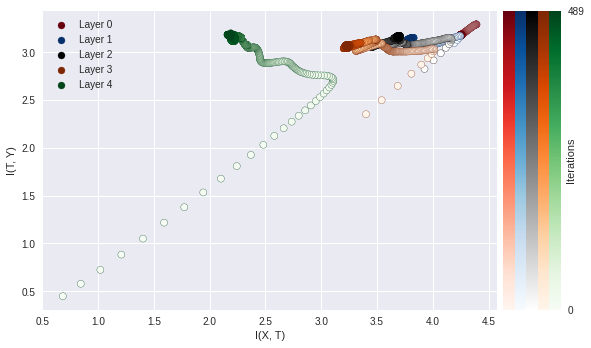

In [17]:
colors=['Reds', 'Blues', 'binary', 'Oranges', 'Greens']
with plt.style.context('seaborn'):
    fig = plt.figure(constrained_layout=False)
    gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.84, wspace=0.05)
    gs2 = fig.add_gridspec(nrows=1, ncols=len(Ixts), left=0.85, right=0.95, wspace=0)
    f8_ax1 = fig.add_subplot(gs1[:, :])
    f8_ax1.set_xlabel("I(X, T)")
    f8_ax1.set_ylabel("I(T, Y)")

    for idx, Ixt in enumerate(Ixts):
        Ity = Itys[idx]
        cmap = plt.cm.get_cmap(colors[idx])
        # Ixt, Ity = ip.getMutualInformation()
        Ixt = moving_average(Ixt, n=10)
        Ity = moving_average(Ity, n=10)
        iterations = np.arange(len(Ixt))
        color = np.array([cmap(iterations[-1])])
        sc = f8_ax1.scatter(Ixt, Ity, c=iterations, vmin=0, vmax=iterations.max(), cmap=cmap, edgecolor=color)
        f8_ax1.scatter([], [], c=color, label="Layer {}".format(idx))

        f8_ax2 = fig.add_subplot(gs2[0, idx])
        cb = fig.colorbar(sc, cax=f8_ax2, pad=0)
        cb.set_ticks([])

    f8_ax1.legend()
    cb.set_ticks([0, iterations.max()])
    cb.set_label("Iterations", labelpad=-18)

    plt.show()

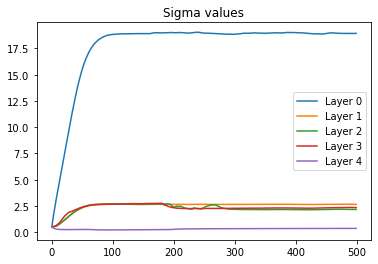

In [13]:
from matplotlib import pyplot as plt
sigma_per_layers = matrix_optimizer.sigma_prev

for idx, sigmas in enumerate(sigma_per_layers):
    plt.plot(sigmas, label="Layer {}".format(idx))

plt.title("Sigma values")
plt.legend()
plt.show()

In [23]:
print(net)

MLP(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MatrixEstimator(sigma=10.83)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1024, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MatrixEstimator(sigma=1.67)
  )
  (layer3): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MatrixEstimator(sigma=1.25)
  )
  (layer4): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MatrixEstimator(sigma=2.50)
  )
  (layer5): Sequent

In [42]:
Ky.device

device(type='cuda', index=0)